# Load Model Weights

In [1]:
from scripts.direct_training import direct_training

df = direct_training.to_dataframe(
    config=dict(
        n_train=10_000,
        dataset_name="C-SYNTH-23M:reasonable"
    )
)
pre_trained_models = dict(zip(df.labels, df.id))
pre_trained_models

{'ace': '23.06.08-20.33.15-394025',
 'gap20': '23.06.09-08.13.03-677890',
 'edip': '23.06.09-22.16.54-046769',
 'lcbop': '23.06.13-08.37.46-604921'}

In [2]:
import torch

pre_trained_states = {
    label: torch.load(f"results/direct_training/version-1/runs/{id}/best_model.pth")
    for label, id in pre_trained_models.items()
}
pre_trained_states.keys()

dict_keys(['ace', 'gap20', 'edip', 'lcbop'])

In [3]:
from scripts.fine_tuning import fine_tuning

df = fine_tuning.to_dataframe(
    config=dict(
        n_finetune=60,
        finetune_dataset="C-GAP-17"
    )
)
fine_tuned_models = {
    label: df[df.pretrain_id == id].id.values[0]
    for label, id in pre_trained_models.items()
}
fine_tuned_models

{'ace': '23.11.01-10.35.49-597714',
 'gap20': '23.11.01-10.38.10-002663',
 'edip': '23.11.01-10.40.21-043863',
 'lcbop': '23.11.01-10.43.01-870278'}

In [4]:
from pathlib import Path

def load_all_state_dicts(dir):
    dir = Path(dir)
    paths = dir.glob("ckpt*.pth")
    nums = sorted([int(p.stem.replace("ckpt", "")) for p in paths])
    return [
        torch.load(dir / f"ckpt{num}.pth")
        for num in nums
    ]

fine_tuned_states_evolution = {
    label: load_all_state_dicts(f"results/fine_tuning/version-1/runs/{id}/")
    for label, id in fine_tuned_models.items()
}
{label: len(states) for label, states in fine_tuned_states_evolution.items()}

{'ace': 49, 'gap20': 49, 'edip': 82, 'lcbop': 105}

In [28]:
direct_id = direct_training.to_dataframe(config=dict(n_train=60, dataset_name="C-GAP-17")).id[0]
direct_states_evolution = load_all_state_dicts(f"results/direct_training/version-1/runs/{direct_id}/")

# Analyse

In [24]:
for key in pre_trained_states["ace"].keys():
    print(tuple(pre_trained_states["ace"][key].shape), "   \t", key.replace("model.func.", ""))

(0,)    	 scale_by
(0,)    	 shift_by
(8,)    	 radial_basis.basis.bessel_weights
(32,)    	 chemical_embedding.linear.weight
(0,)    	 chemical_embedding.linear.bias
(32,)    	 chemical_embedding.linear.output_mask
(0,)    	 layer0_convnet.equivariant_nonlin.mul.weight
(96,)    	 layer0_convnet.equivariant_nonlin.mul.output_mask
(1024,)    	 layer0_convnet.conv.linear_1.weight
(0,)    	 layer0_convnet.conv.linear_1.bias
(32,)    	 layer0_convnet.conv.linear_1.output_mask
(8, 8)    	 layer0_convnet.conv.fc.layer0.weight
(8, 64)    	 layer0_convnet.conv.fc.layer1.weight
(0,)    	 layer0_convnet.conv.tp.weight
(128,)    	 layer0_convnet.conv.tp.output_mask
(3072,)    	 layer0_convnet.conv.linear_2.weight
(0,)    	 layer0_convnet.conv.linear_2.bias
(160,)    	 layer0_convnet.conv.linear_2.output_mask
(2048,)    	 layer0_convnet.conv.sc.weight
(160,)    	 layer0_convnet.conv.sc.output_mask
(0,)    	 layer1_convnet.equivariant_nonlin.mul.weight
(192,)    	 layer1_convnet.equivariant_nonlin.

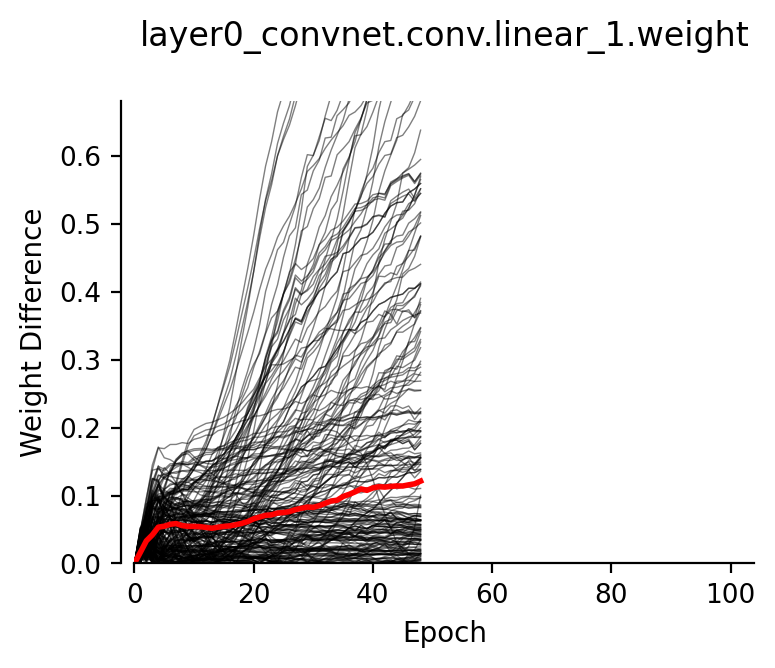

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


colours = {
    "dft": "black",
    # empirical colours are blues
    "lcbop": "#6fa8dc",
    "edip": "#77c9a8",
    # synthetic colours are reds and oranges
    # "ace": "#cc4125",
    "ace": "red",
    "gap20": "#ffa319",
    "qsnap": "#f1c232",
}

display_name = {
    "ace": "ACE",
    "gap20": "GAP-20U",
    "lcbop": "LCBOP",
    "edip": "EDIP",
}

def difference_plot(thing, label, N=200, ax=None):
    if ax is None:
        plt.figure(figsize=(4, 3))
        ax = plt.gca()
    
    if not thing.startswith("model.func."):
        thing = "model.func." + thing

    pre_trained_thing = pre_trained_states[label][thing].cpu().numpy().flatten()
    fine_tuned_things = np.array([
        state[thing].cpu().numpy().flatten()
        for state in fine_tuned_states_evolution[label]
    ])

    difference = np.abs((fine_tuned_things - pre_trained_thing))

    idx = np.random.RandomState(0).choice(difference.shape[1], N)
    ax.plot(difference[:, idx],"-k", lw=0.5, alpha=0.5)
    ax.plot(np.median(difference, axis=1), "-", lw=2, c=colours[label])
    lim = np.quantile(difference[-1], 0.9)
    ax.set_ylim(0, lim)
    ax.set_xlim(left=0, right=104)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Weight Difference")
    for despine in ["top", "right"]:
        ax.spines[despine].set_visible(False)
    ax.spines["left"].set_position(("outward", 5))


difference_plot("layer0_convnet.conv.linear_1.weight", "ace")
plt.title("layer0_convnet.conv.linear_1.weight", pad=20);

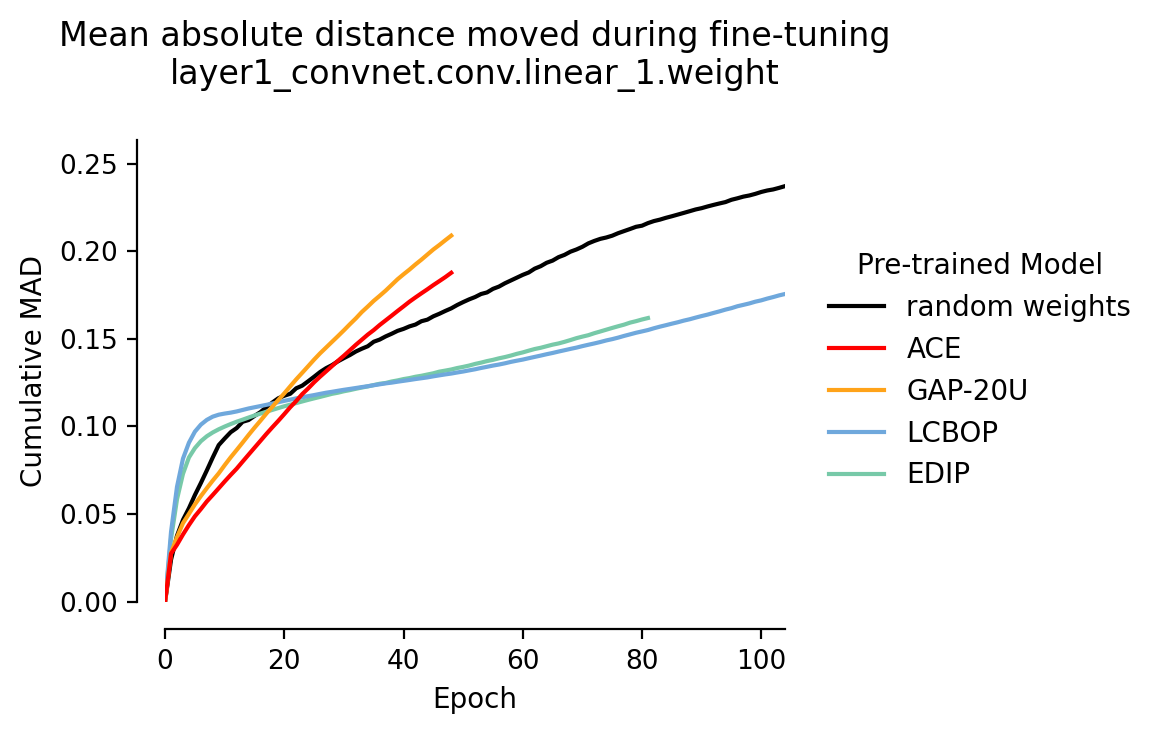

In [34]:
from plotting_utils import style_defaults
plt.rcParams.update(style_defaults)

thing = "layer1_convnet.conv.linear_1.weight"

plt.figure(figsize=(4, 3))



direct_things = np.array([
    state["model.func." + thing].cpu().numpy()
    for state in direct_states_evolution
])
direct_diff = np.abs(direct_things - direct_things[0]).mean(axis=1)
plt.plot(direct_diff, label="random weights", c=colours["dft"], zorder=0)


for i, label in enumerate(("ace", "gap20", "lcbop", "edip")):
    pre_trained_thing = pre_trained_states[label]["model.func." + thing].cpu().numpy()
    fine_tuned_things = np.array([
        state["model.func." + thing].cpu().numpy()
        for state in fine_tuned_states_evolution[label]
    ])

    # normalised euclidean distance between each epoch and the pre-trained model
    # diff = np.linalg.norm(fine_tuned_things - pre_trained_thing, axis=1) / np.sqrt(fine_tuned_things.shape[1])
    diff = np.abs(fine_tuned_things - pre_trained_thing).mean(axis=1)

    plt.plot(diff, label=display_name[label], c=colours[label], zorder=10-i)



plt.ylim(bottom=0)
plt.xlim(left=0, right=104)
plt.xlabel("Epoch")
plt.ylabel("Cumulative MAD")
ax = plt.gca()
ax.spines["left"].set_position(("outward", 10))
ax.spines["bottom"].set_position(("outward", 10))

plt.legend(loc="center left", title="Pre-trained Model", bbox_to_anchor=(1.03, 0.5), frameon=False)
plt.title(f"Mean absolute distance moved during fine-tuning\n{thing}", pad=20);

/tmp/ipykernel_3948405/4127772115.py:11: RuntimeWarning: Mean of empty slice.
  direct_diff = np.abs(direct_things - direct_things[0]).mean(axis=1)
/u/vld/jesu2890/miniconda3/envs/pre-train-nequip/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_3948405/4127772115.py:22: RuntimeWarning: Mean of empty slice.
  diff = np.abs(fine_tuned_things - pre_trained_thing).mean(axis=1)


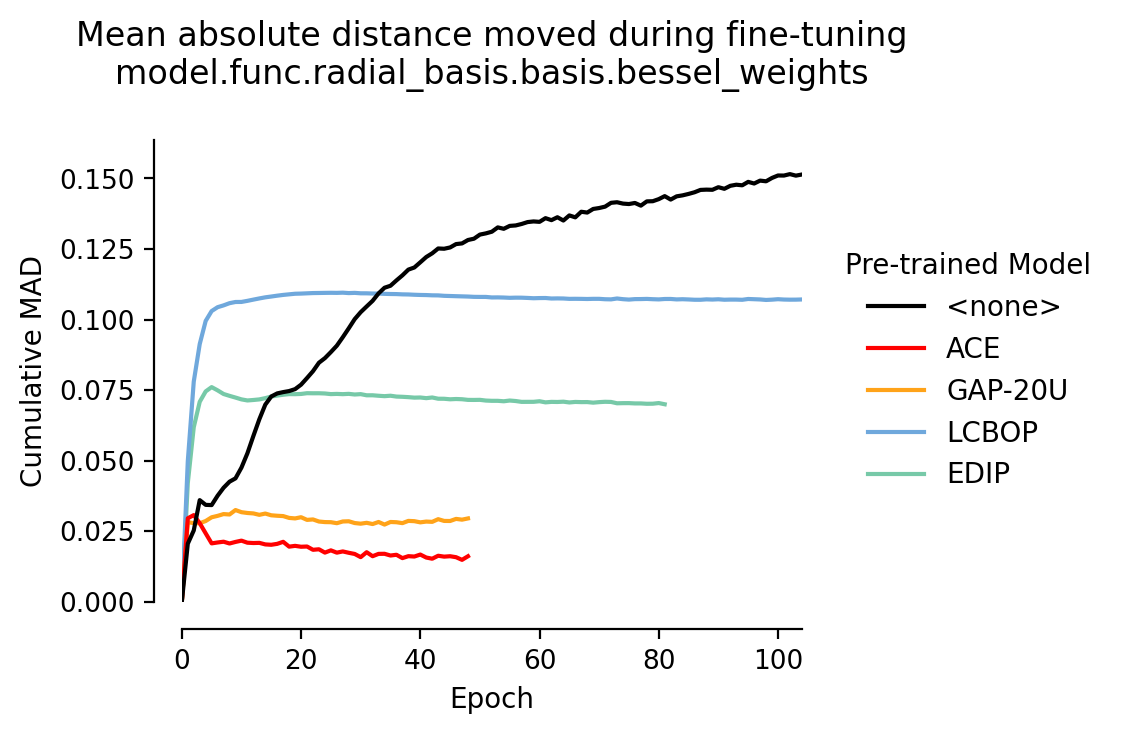

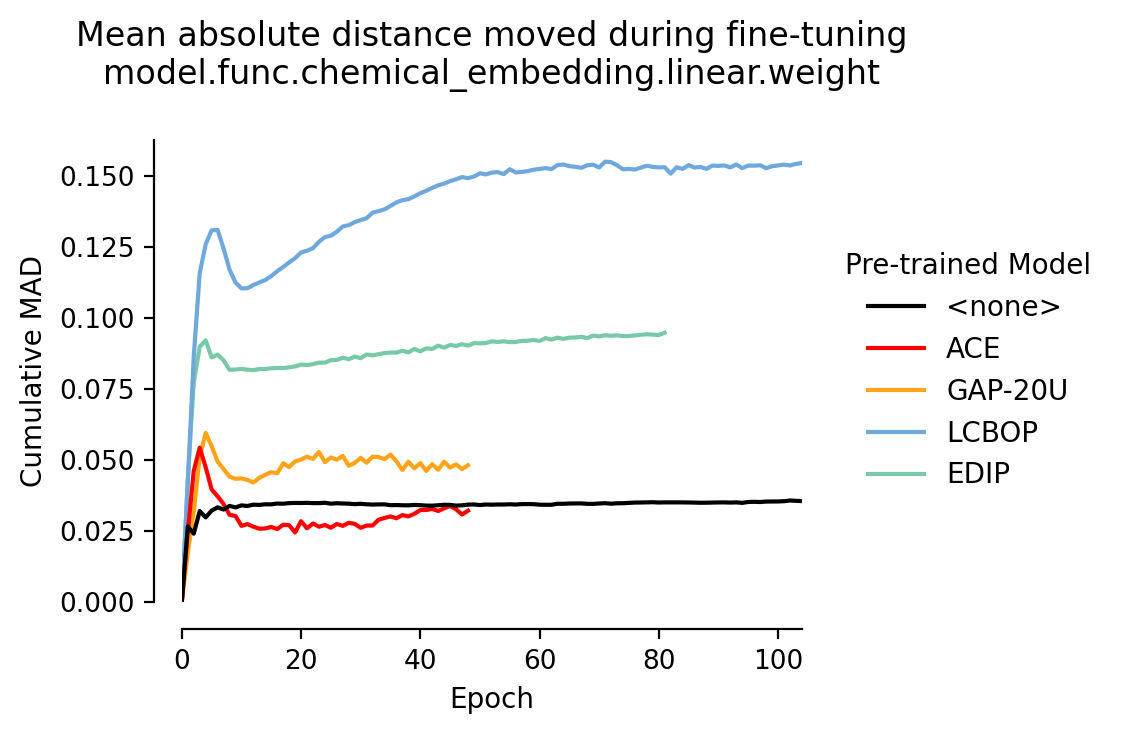

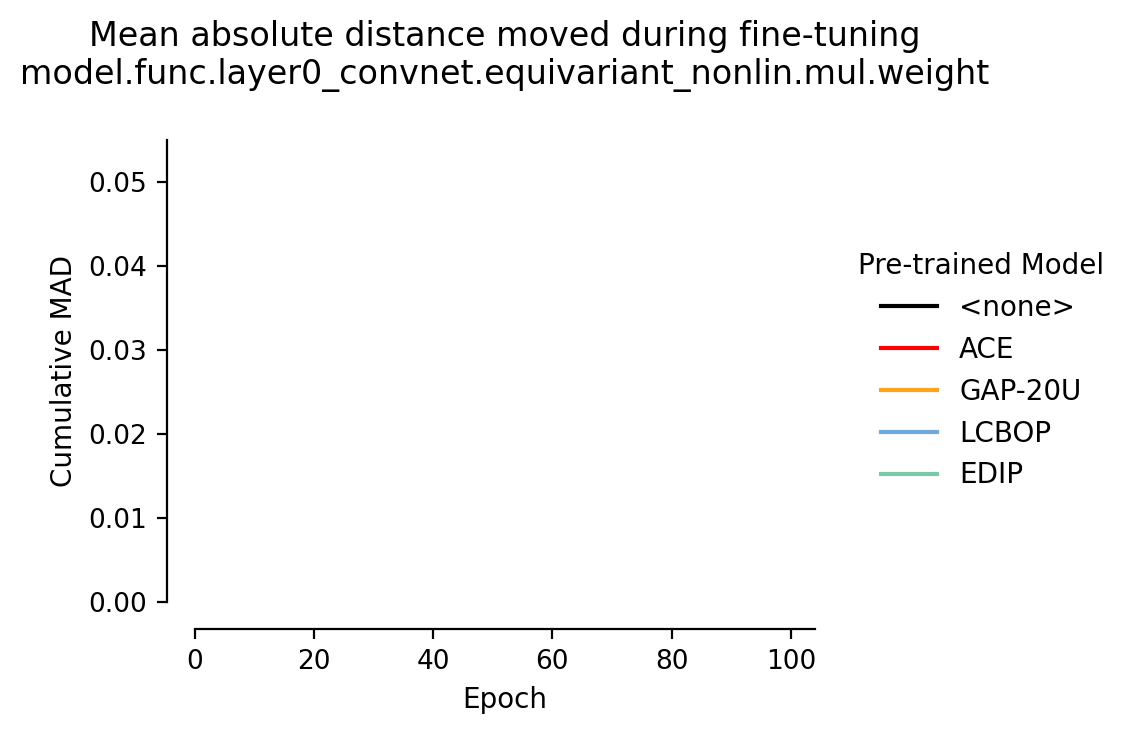

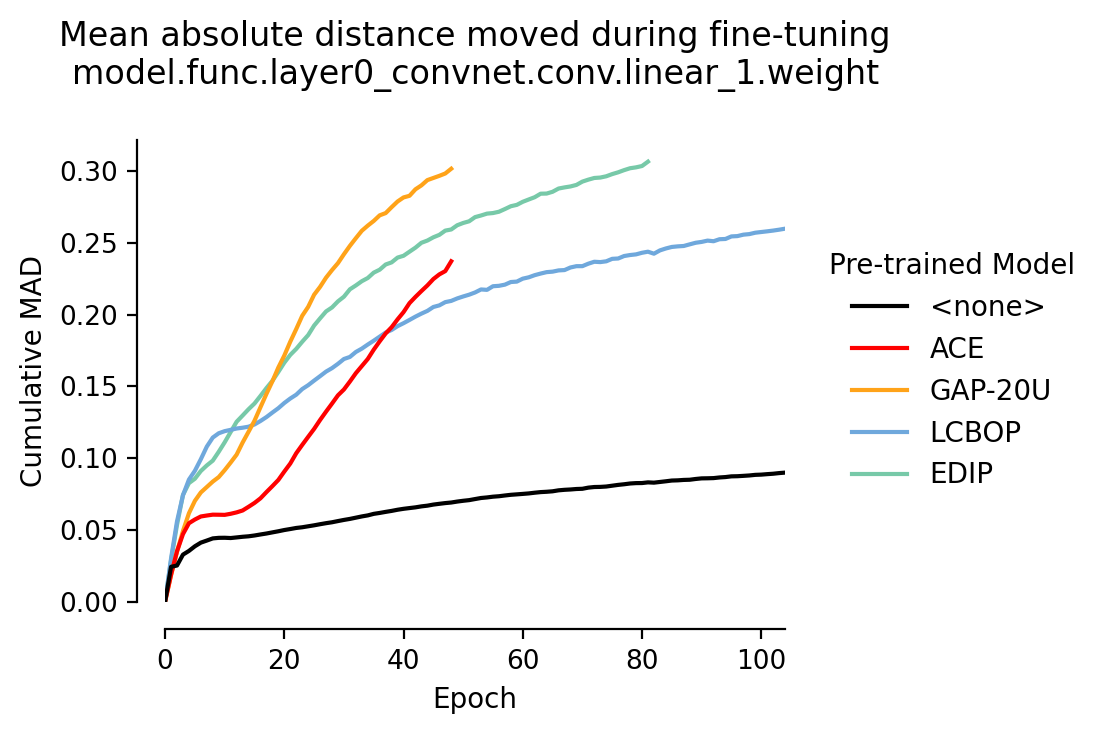

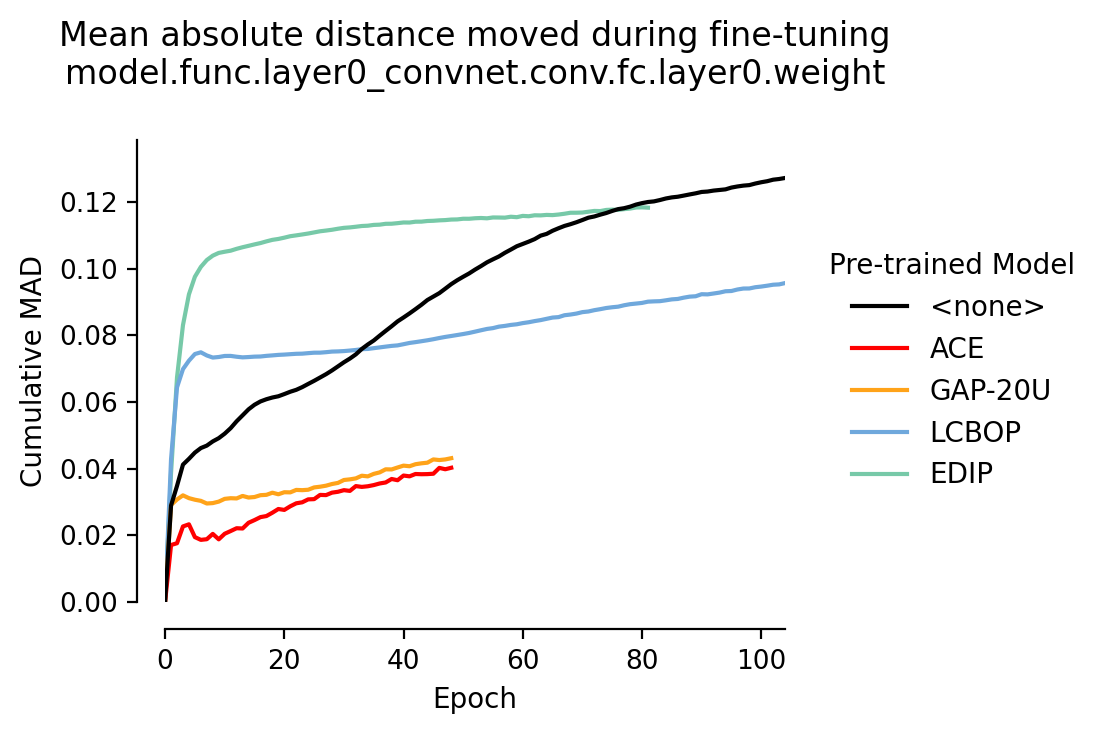

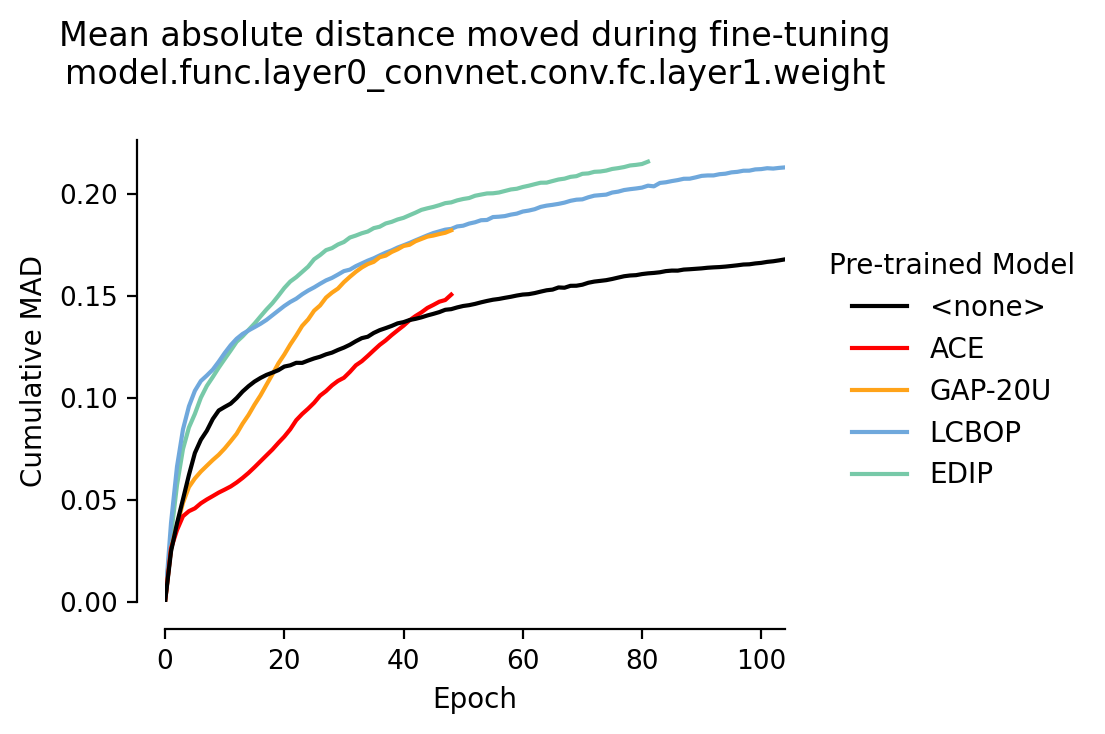

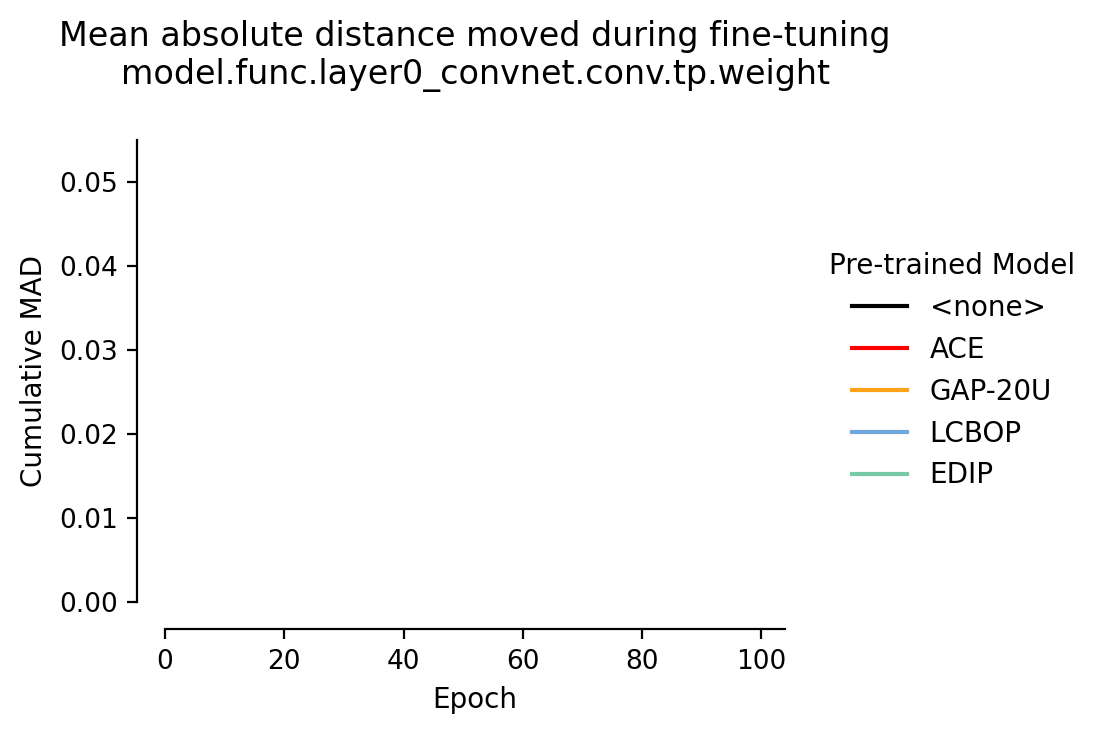

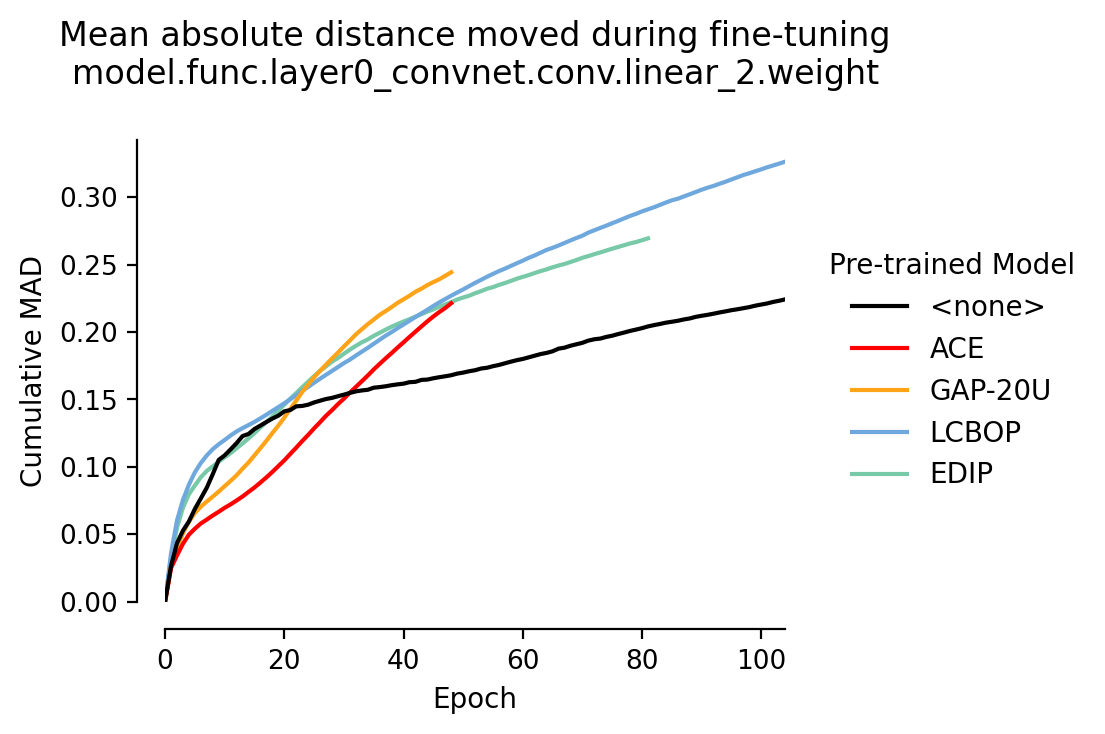

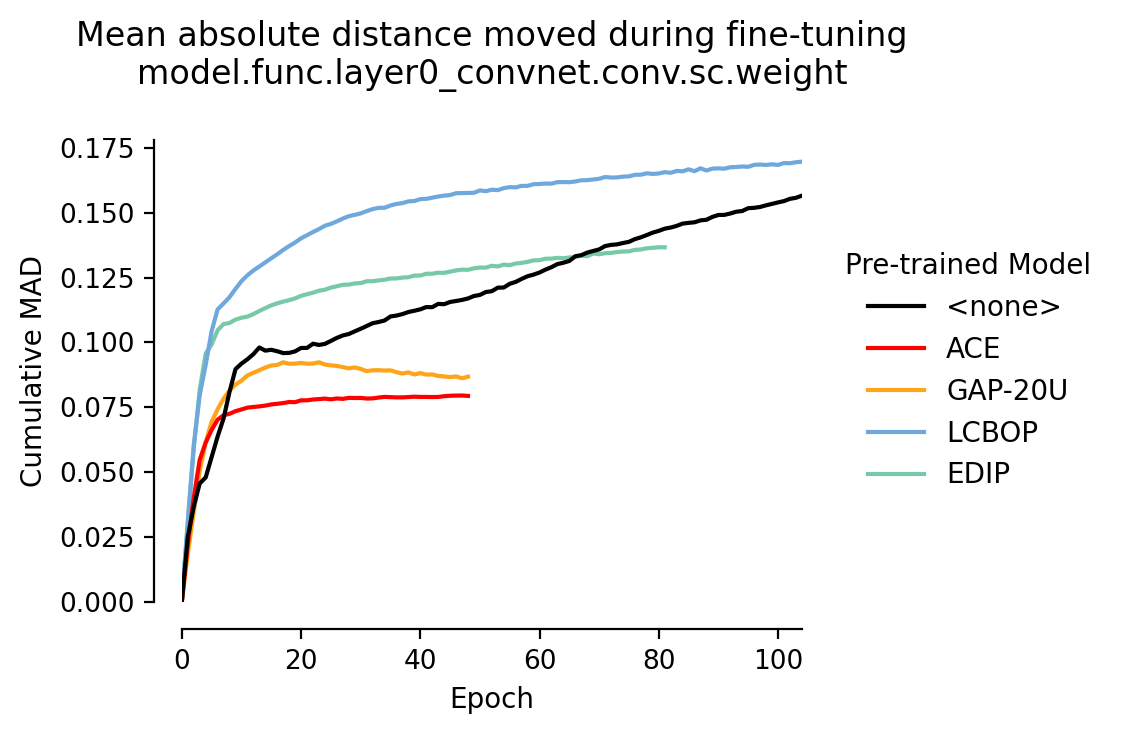

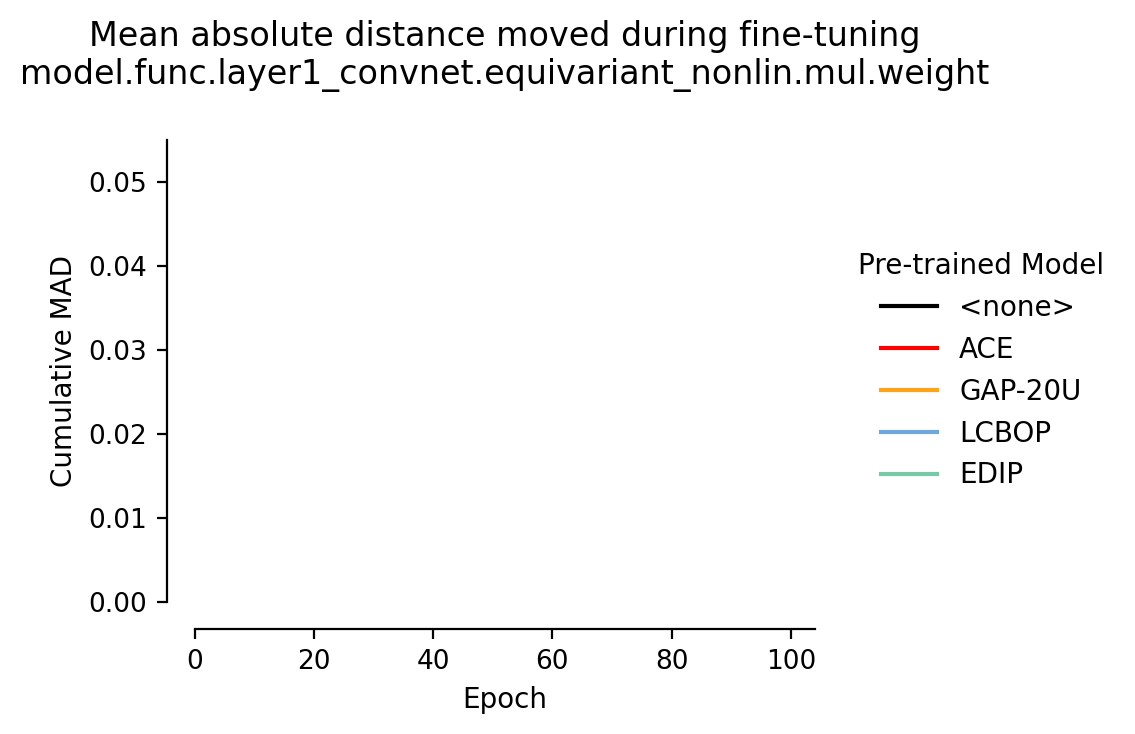

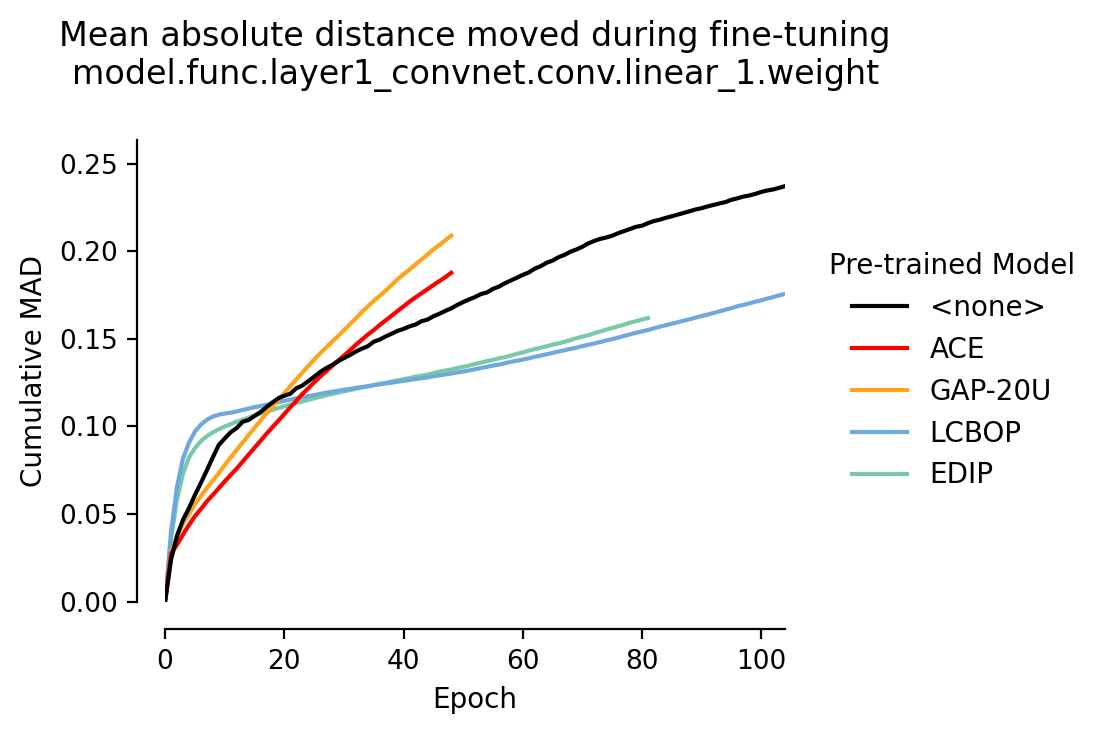

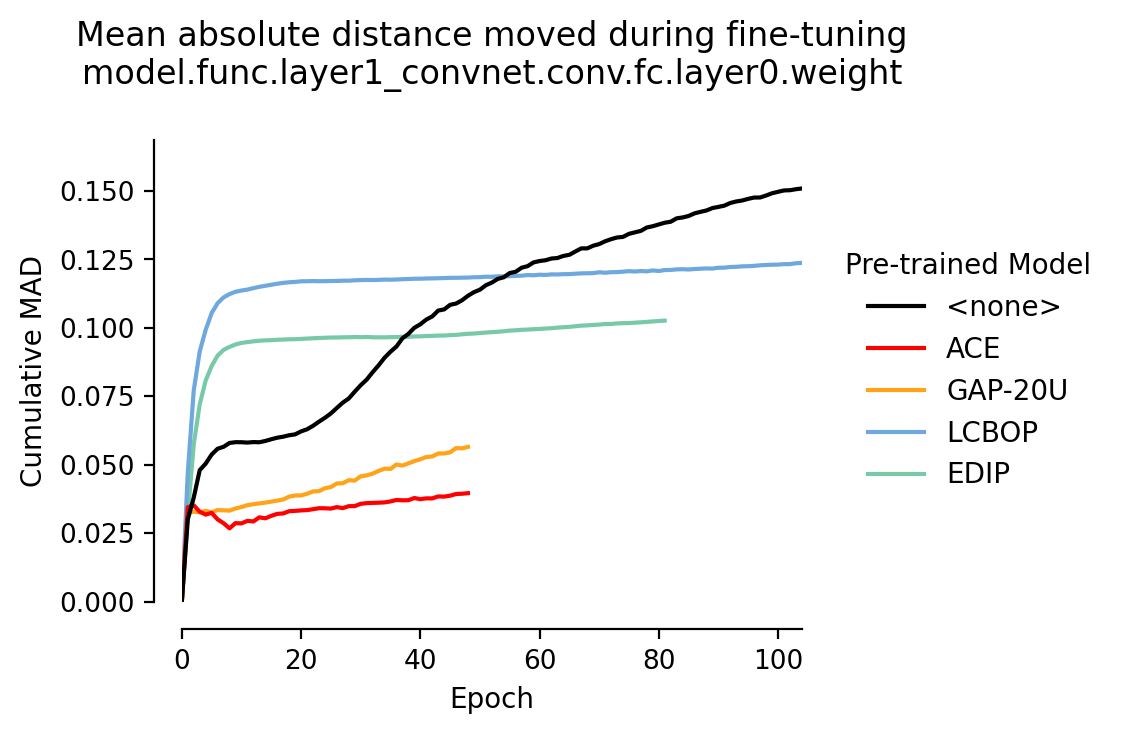

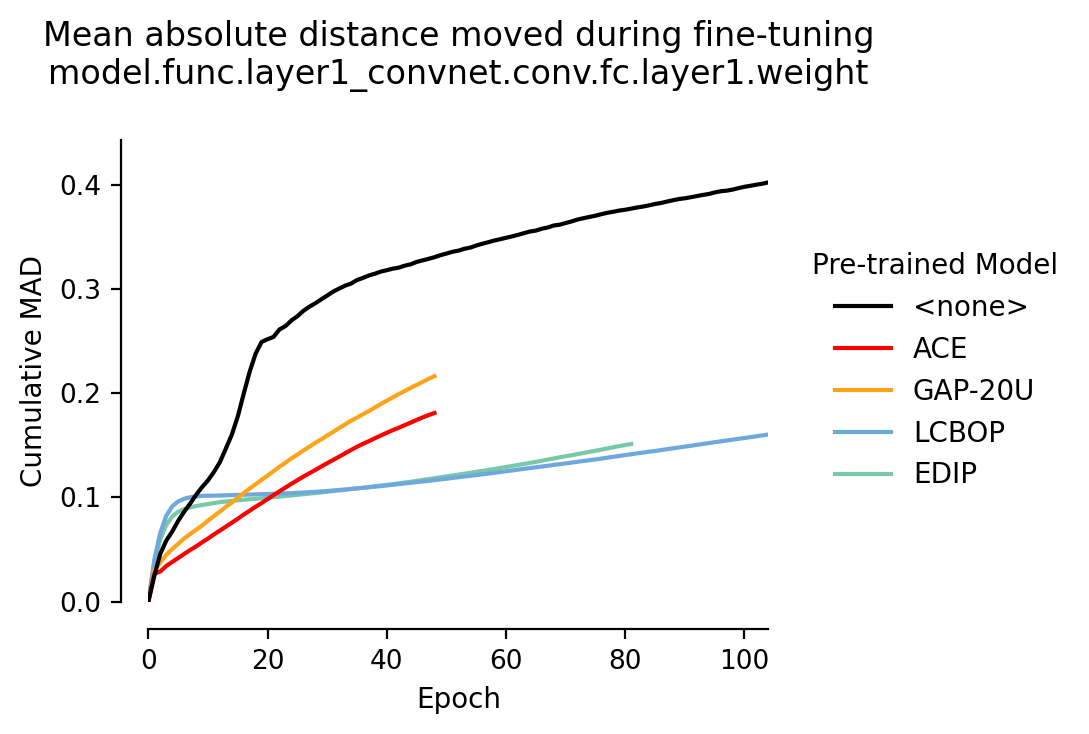

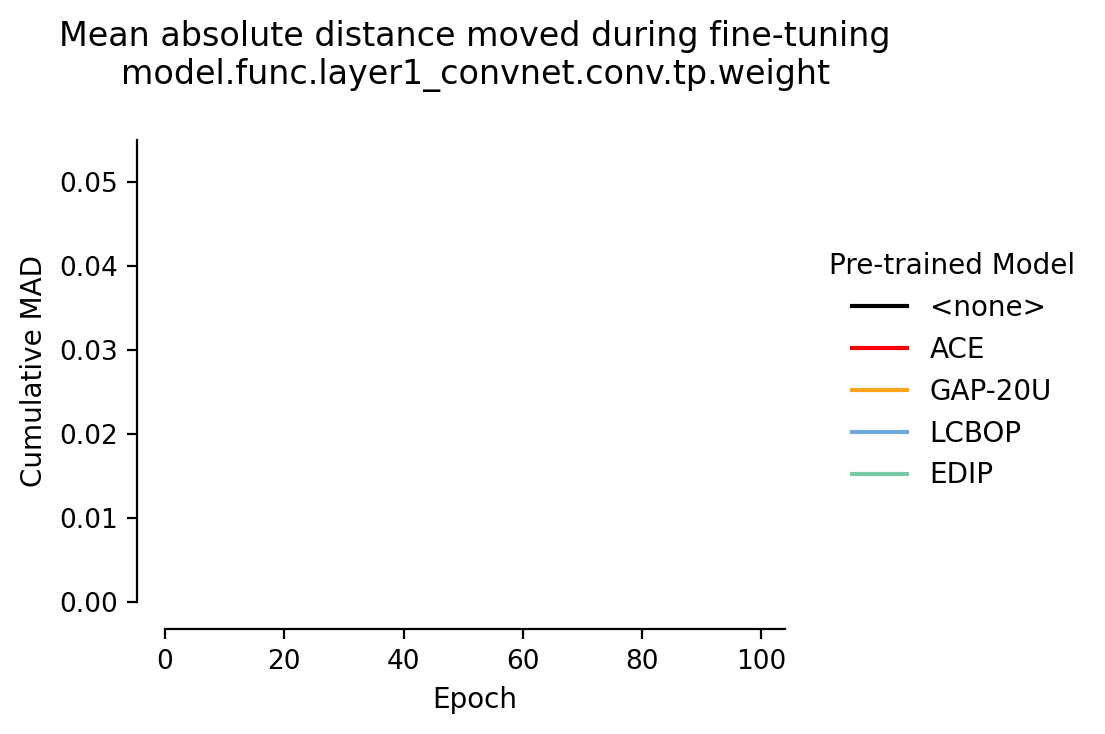

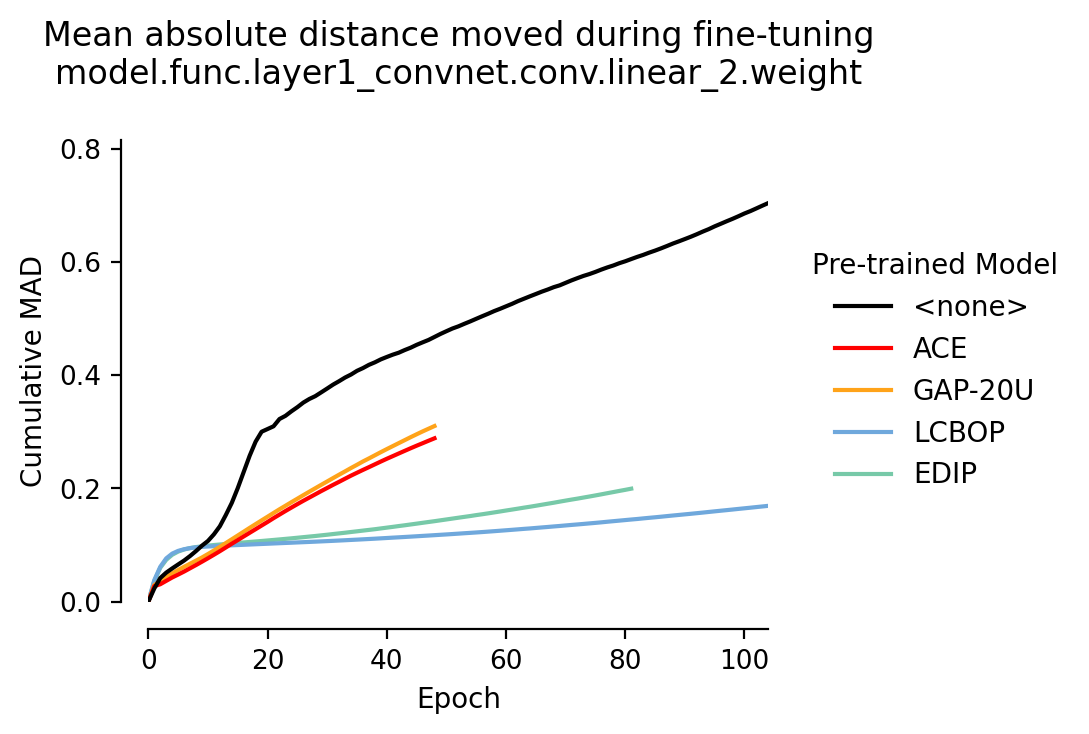

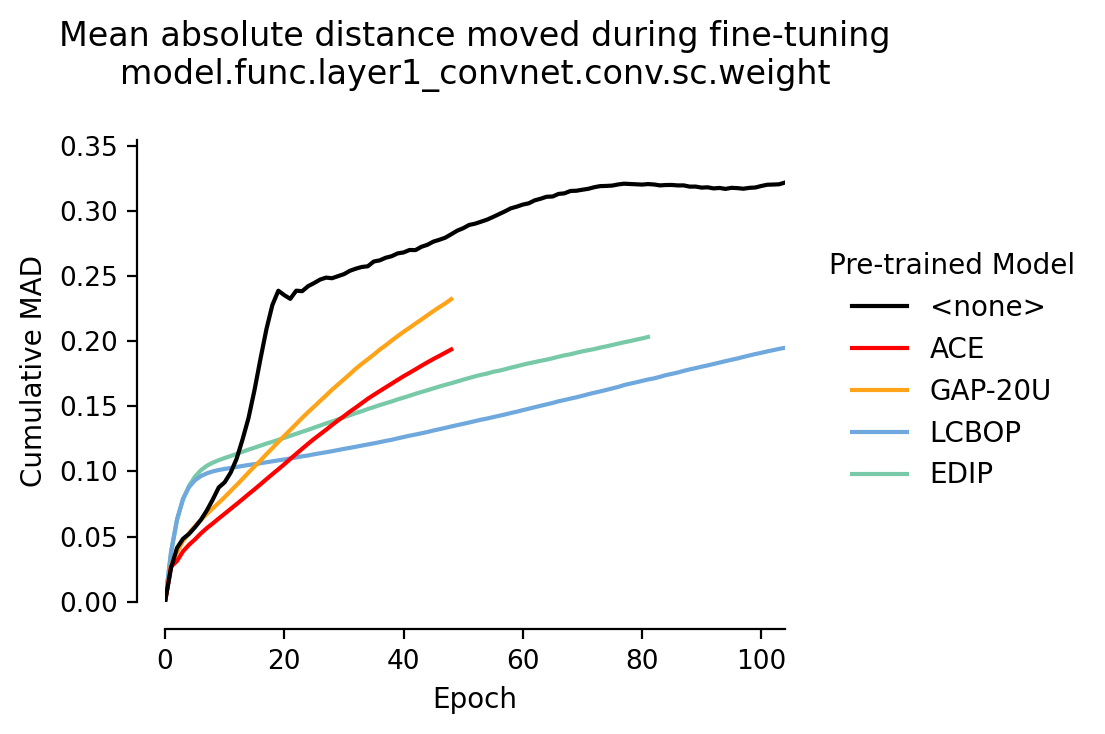

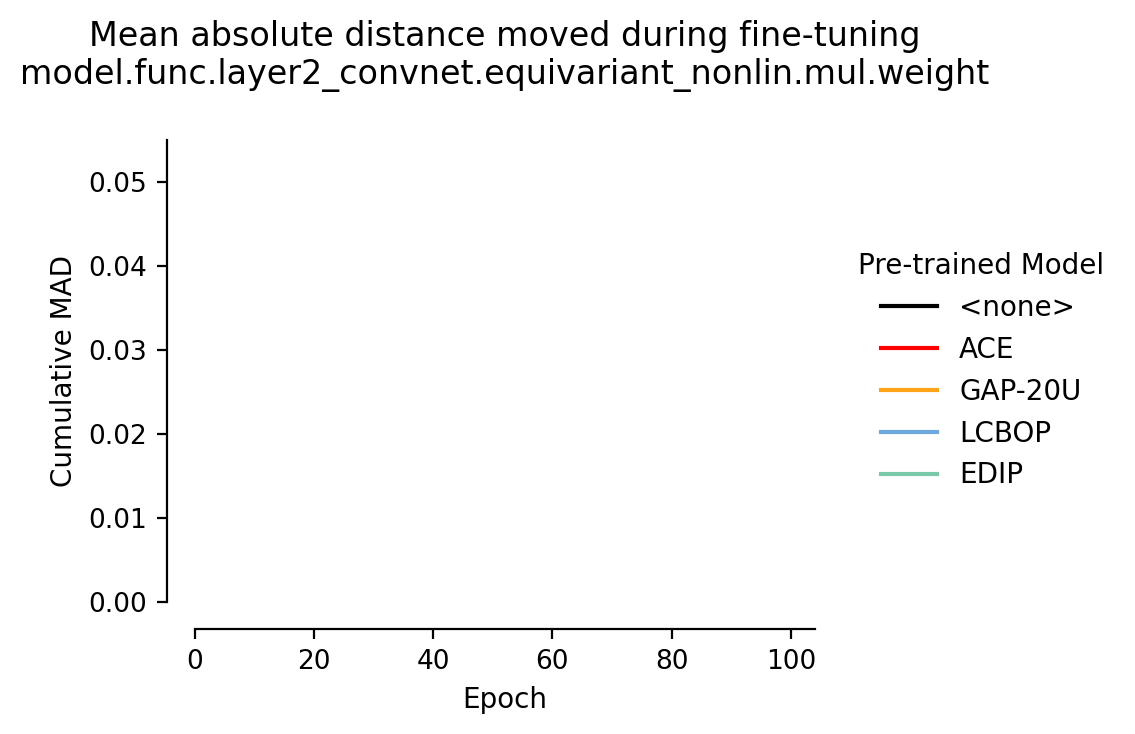

In [42]:
for thing in pre_trained_states["ace"].keys():
    if "weight" not in thing:
        continue

    plt.figure(figsize=(4, 3))

    direct_things = np.array([
        state[thing].cpu().numpy().flatten()
        for state in direct_states_evolution
    ])
    direct_diff = np.abs(direct_things - direct_things[0]).mean(axis=1)
    plt.plot(direct_diff, label="<none>", c=colours["dft"], zorder=20)

    for i, label in enumerate(("ace", "gap20", "lcbop", "edip")):
        pre_trained_thing = pre_trained_states[label][thing].cpu().numpy().flatten()
        fine_tuned_things = np.array([
            state[thing].cpu().numpy().flatten()
            for state in fine_tuned_states_evolution[label]
        ])

        # normalised euclidean distance between each epoch and the pre-trained model
        diff = np.abs(fine_tuned_things - pre_trained_thing).mean(axis=1)
        plt.plot(diff, label=display_name[label], c=colours[label], zorder=10-i)


    plt.ylim(bottom=0)
    plt.xlim(left=0, right=104)
    plt.xlabel("Epoch")
    plt.ylabel("Cumulative MAD")
    ax = plt.gca()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    plt.legend(loc="center left", title="Pre-trained Model", bbox_to_anchor=(1.03, 0.5), frameon=False)
    plt.title(f"Mean absolute distance moved during fine-tuning\n{thing}", pad=20);     